## 2 Goal Oriented Risk Management

1. VaR for Normal Distribution

95% VaR:  1.6448536269514722 ; 99% VaR:  2.2984914645286385


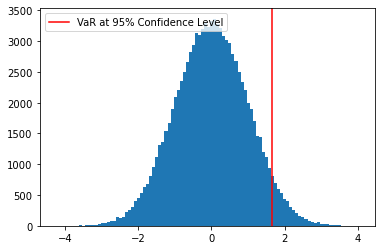

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas_datareader as web

# Create the VaR measure at the 95% confidence level using norm.ppf()
VaR_95 = norm.ppf(0.95)

# Create the VaR measure at the 5% significance level using numpy.quantile()
draws = norm.rvs(size = 100000)
VaR_99 = np.quantile(draws, 0.99)

# Compare the 95% and 99% VaR
print("95% VaR: ", VaR_95, "; 99% VaR: ", VaR_99)

# Plot the normal distribution histogram and 95% VaR measure
plt.hist(draws, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.legend(); plt.show()

Import Data

In [37]:
#  Assets to be included in the portfolio
tickers = ['C', 'MS', 'GS', 'JPM']
portfolio = web.get_data_yahoo(tickers, start = '2005-01-02',end = '2010-12-30')
portfolio = portfolio['Adj Close']
# Ensure the prices are sorted by Date
portfolio = portfolio.sort_values(by='Date')

In [75]:
# Calculate daily returns of stocks
portfolio_returns=portfolio.pct_change().dropna()
# Compute (4 banks equal weights) returns for 2005-2010
weights= [0.25, 0.25, 0.25, 0.25]
portfolio_losses=portfolio_returns@weights
print(portfolio_losses)

Date
2005-01-04   -0.009003
2005-01-05    0.001081
2005-01-06    0.013209
2005-01-07   -0.005479
2005-01-10   -0.002007
                ...   
2010-12-23   -0.005974
2010-12-27    0.012551
2010-12-28    0.000594
2010-12-29   -0.007729
2010-12-30   -0.000818
Length: 1509, dtype: float64


2. Compating VaR and CVaR <br>

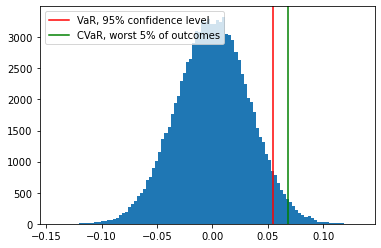

VaR_95: 0.0547167827014033 CVaR_95: 0.06851039419078216


In [76]:
#The conditional value at risk (CVaR), or expected shortfall (ES), asks what the average loss will be, 
#conditional upon losses exceeding some threshold at a certain confidence level. 
#It uses VaR as a point of departure, but contains more information because 
#it takes into consideration the tail of the loss distribution.

# Compute the mean and variance of the portfolio returns
pm = portfolio_losses.mean()
ps = portfolio_losses.std()

# Compute the 95% VaR using the .ppf()
VaR_95 = norm.ppf(0.95, loc = pm, scale = ps)
# Compute the expected tail loss and the CVaR in the worst 5% of cases
# CVaR= 1/(1 / (1 - qunatile))*integral(x*f(x))|lb=quantile
tail_loss = norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_95)
CVaR_95 = (1 / (1 - 0.95)) * tail_loss

# Plot the normal distribution histogram and add lines for the VaR and CVaR
plt.hist(norm.rvs(size = 100000, loc = pm, scale = ps), bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR, 95% confidence level")
plt.axvline(x = CVaR_95, c='g', label = "CVaR, worst 5% of outcomes")
plt.legend(); plt.show()
print('VaR_95:', VaR_95, 'CVaR_95:', CVaR_95)

3. VaR and CVaR Risk exposure

In [86]:
# Import the Student's t-distribution
from scipy.stats import t
#portfolio_losses.columns=['Date','Loss']
#print(portfolio_losses.columns)
#losses=pd.DataFrame({'Date':portfolio_losses.index, 'loss':portfolio_losses['Loss']})
losses=pd.DataFrame(portfolio_losses)
print(losses.info())
#portfolio_losses.to_frame(name='Loss')
#losses.set_index('Date', inplace=True)
print(losses.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2005-01-04 to 2010-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1509 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB
None
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-18',
               ...
               '2010-12-16', '2010-12-17', '2010-12-20', '2010-12-21',
               '2010-12-22', '2010-12-23', '2010-12-27', '2010-12-28',
               '2010-12-29', '2010-12-30'],
              dtype='datetime64[ns]', name='Date', length=1509, freq=None)


                   0
Date                
2005-01-04       NaN
2005-01-05       NaN
2005-01-06       NaN
2005-01-07       NaN
2005-01-10       NaN
...              ...
2010-12-23  0.014258
2010-12-27  0.014279
2010-12-28  0.013859
2010-12-29  0.013883
2010-12-30  0.013506

[1509 rows x 1 columns]
[(29, Date
2005-01-04         NaN
2005-01-05         NaN
2005-01-06         NaN
2005-01-07         NaN
2005-01-10         NaN
                ...   
2010-12-23    0.001197
2010-12-27    0.001902
2010-12-28    0.002469
2010-12-29    0.001844
2010-12-30    0.002332
Name: 0, Length: 1509, dtype: float64, 0)]


C:\ProgramData\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\ProgramData\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


ValueError: x and y must have same first dimension, but have shapes (1509,) and (1, 1509)

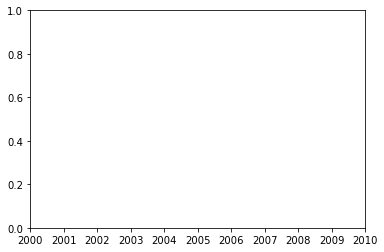

In [97]:
# Create rolling window parameter list
mu = losses.rolling(30).mean()
sigma = losses.rolling(30).std()
rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)]
print(sigma)
print(rolling_parameters)
# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ t.ppf(0.99, *params) 
                    for params in rolling_parameters] )

# Plot the minimum risk exposure over the 2005-2010 time period
plt.plot(losses.index, 0.01 * VaR_99 * 100000)
plt.show()